# Late Fusion by Ambiguity Groups - BALANCED (Stratified Sampling)

This notebook splits trials into ambiguity groups with **STRATIFIED SAMPLING** to ensure each subject contributes equally to each group.

In [21]:
import pickle
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, f1_score
from sklearn.impute import SimpleImputer
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## 1. Load Pre-Extracted Features

In [22]:
# Load pre-extracted features
with open('../../data/results/features_PRE/extracted_features_PRE.pkl', 'rb') as f:
    feature_data = pickle.load(f)

merged_df = feature_data['merged_df']
physio_cols = feature_data['physio_cols']
behavior_cols = feature_data['behavior_cols']
gaze_cols = feature_data['gaze_cols']

print(f"✓ Loaded {len(merged_df)} trials from {merged_df['subject_id'].nunique()} subjects")
print(f"  Features extracted on: {feature_data['metadata']['extraction_date']}")
print(f"\nAmbiguity distribution:")
print(merged_df['ambiguity'].value_counts().sort_index())


✓ Loaded 12511 trials from 97 subjects
  Features extracted on: 2025-12-27 14:10:40

Ambiguity distribution:
ambiguity
0    4177
3    4162
6    4172
Name: count, dtype: int64


## 2. Create Ambiguity Groups with Stratified Sampling

In [23]:
# Create ambiguity groups
merged_df['ambiguity_group'] = merged_df['ambiguity'].replace({0:'Low', 3:'Medium', 6:'High'})

print("Original ambiguity group distribution:")
print(merged_df['ambiguity_group'].value_counts())

# Perform stratified sampling to balance subjects across groups
print("\n" + "="*80)
print("STRATIFIED SAMPLING: Ensuring equal subject representation")
print("="*80)

balanced_data = []
for group in ['Low', 'Medium', 'High']:
    group_data = merged_df[merged_df['ambiguity_group'] == group].copy()
    
    # Find minimum trials per subject in this group
    subject_counts = group_data.groupby('subject_id').size()
    min_trials = subject_counts.min()
    
    print(f"\n{group} Ambiguity:")
    print(f"  Original: {len(group_data)} trials")
    print(f"  Min trials per subject: {min_trials}")
    print(f"  Sampling {min_trials} trials from each of {subject_counts.nunique()} subjects")
    
    # Sample exactly min_trials from each subject
    balanced_group_data = []
    for subject in group_data['subject_id'].unique():
        subject_data = group_data[group_data['subject_id'] == subject]
        sampled = subject_data.sample(n=min_trials, random_state=42)
        balanced_group_data.append(sampled)
    
    balanced_group = pd.concat(balanced_group_data, ignore_index=True)
    print(f"  After balancing: {len(balanced_group)} trials ({len(balanced_group) / len(group_data) * 100:.1f}% of original)")
    balanced_data.append(balanced_group)

merged_df_balanced = pd.concat(balanced_data, ignore_index=True)

print(f"\n{'='*80}")
print(f"SUMMARY:")
print(f"  Original total: {len(merged_df)} trials")
print(f"  Balanced total: {len(merged_df_balanced)} trials")
print(f"  Data retained: {len(merged_df_balanced) / len(merged_df) * 100:.1f}%")
print(f"  Data lost: {(1 - len(merged_df_balanced) / len(merged_df)) * 100:.1f}%")
print(f"\nBalanced distribution:")
print(merged_df_balanced['ambiguity_group'].value_counts())

Original ambiguity group distribution:
ambiguity_group
Low       4177
High      4172
Medium    4162
Name: count, dtype: int64

STRATIFIED SAMPLING: Ensuring equal subject representation

Low Ambiguity:
  Original: 4177 trials
  Min trials per subject: 4
  Sampling 4 trials from each of 24 subjects
  After balancing: 388 trials (9.3% of original)

Medium Ambiguity:
  Original: 4162 trials
  Min trials per subject: 2
  Sampling 2 trials from each of 25 subjects
  After balancing: 194 trials (4.7% of original)

High Ambiguity:
  Original: 4172 trials
  Min trials per subject: 3
  Sampling 3 trials from each of 25 subjects
  After balancing: 291 trials (7.0% of original)

SUMMARY:
  Original total: 12511 trials
  Balanced total: 873 trials
  Data retained: 7.0%
  Data lost: 93.0%

Balanced distribution:
ambiguity_group
Low       388
High      291
Medium    194
Name: count, dtype: int64


## 3. Prepare Feature Sets

In [24]:
physio_cols = [c for c in merged_df_balanced.columns if c.endswith('_pre')]
behavior_cols = ['reaction_time', 'decision_time', 'ev_difference', 
                 'invest_variance', 'condition_social', 'risk_premium']
gaze_cols = [c for c in merged_df_balanced.columns 
             if c.startswith('gaze_') or c.startswith('screen_') or 
             c in ['fixation_ratio', 'saccade_ratio', 'saccade_count', 'gaze_valid_pct',
                   'gaze_dispersion_x', 'gaze_dispersion_y', 'gaze_path_length']]

print(f"Physiology (PRE): {len(physio_cols)} features")
print(f"Behavior: {len(behavior_cols)} features")
print(f"Gaze: {len(gaze_cols)} features")

Physiology (PRE): 13 features
Behavior: 6 features
Gaze: 20 features


In [25]:
from scipy import stats

def weighted_late_fusion(X_modalities, y, subjects, modality_names):
    """
    Weighted late fusion using LOSO cross-validation.
    Returns subject-level metrics for proper SEM calculation.
    """
    logo = LeaveOneGroupOut()
    base_models = [RandomForestClassifier(n_estimators=100, max_depth=5, 
                                          min_samples_split=10, min_samples_leaf=5, 
                                          random_state=42,
                                          class_weight='balanced')
                   for _ in X_modalities]
    
    # Store subject-level results
    subject_accs = {}
    subject_f1s = {}
    all_weights = []
    
    for train_idx, test_idx in logo.split(X_modalities[0], y, subjects):
        train_probs, test_probs = [], []
        
        for X, model in zip(X_modalities, base_models):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train = y[train_idx]
            
            model.fit(X_train, y_train)
            train_probs.append(model.predict_proba(X_train)[:, 1])
            test_probs.append(model.predict_proba(X_test)[:, 1])
        
        train_probs = np.column_stack(train_probs)
        test_probs = np.column_stack(test_probs)
        y_train, y_test = y[train_idx], y[test_idx]
        
        meta = LogisticRegression(random_state=42, max_iter=1000)
        meta.fit(train_probs, y_train)
        weights = meta.coef_[0]
        y_pred = meta.predict(test_probs)
        
        # Store subject-level metrics
        test_subject = subjects[test_idx][0]
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        subject_accs[test_subject] = acc
        subject_f1s[test_subject] = f1
        all_weights.append(weights)
    
    # Convert to arrays
    subject_acc_values = np.array(list(subject_accs.values()))
    subject_f1_values = np.array(list(subject_f1s.values()))
    
    avg_weights = np.mean(all_weights, axis=0)
    norm_weights = np.exp(avg_weights) / np.sum(np.exp(avg_weights))
    
    return {
        'accuracy_mean': np.mean(subject_acc_values),
        'accuracy_sem': stats.sem(subject_acc_values),
        'accuracy_std': np.std(subject_acc_values),
        'accuracy_per_subject': subject_acc_values,
        'f1_mean': np.mean(subject_f1_values),
        'f1_sem': stats.sem(subject_f1_values),
        'f1_std': np.std(subject_f1_values),
        'f1_per_subject': subject_f1_values,
        'weights': norm_weights,
        'n_trials': len(y),
        'n_subjects': len(subject_accs),
    }

## 4. Define Weighted Late Fusion Function

In [26]:
modality_names = ['Physiology (PRE)', 'Behavior', 'Gaze']
group_results = {}

for group in ['Low', 'Medium', 'High']:
    print(f"\n{'='*80}")
    print(f"Ambiguity Group: {group} (BALANCED)")
    print(f"{'='*80}")
    
    # Use BALANCED data
    group_data = merged_df_balanced[merged_df_balanced['ambiguity_group'] == group]
    
    if len(group_data) < 20:
        print(f"Insufficient data ({len(group_data)} trials). Skipping.")
        continue
    
    # Check if we have enough subjects
    n_subjects = group_data['subject_id'].nunique()
    if n_subjects < 3:
        print(f"Insufficient subjects ({n_subjects}). Skipping.")
        continue
    
    print(f"Trials: {len(group_data)}")
    print(f"Subjects: {n_subjects}")
    print(f"Outcome distribution: {group_data['outcome'].value_counts().to_dict()}")
    
    # Show per-subject trial counts for this group (should all be equal now)
    subject_counts = group_data['subject_id'].value_counts().sort_index()
    print(f"Trials per subject: min={subject_counts.min()}, max={subject_counts.max()}, mean={subject_counts.mean():.1f}")
    print(f"✓ All subjects equally represented!" if subject_counts.min() == subject_counts.max() else "✗ Still imbalanced")
    
    X_physio = SimpleImputer(strategy='mean').fit_transform(group_data[physio_cols])
    X_behavior = SimpleImputer(strategy='mean').fit_transform(group_data[behavior_cols])
    X_gaze = SimpleImputer(strategy='mean').fit_transform(group_data[gaze_cols])
    y = group_data['outcome'].values
    subjects = group_data['subject_id'].values
    
    X_modalities = [X_physio, X_behavior, X_gaze]
    
    results = weighted_late_fusion(X_modalities, y, subjects, modality_names)
    group_results[group] = results
    
    print(f"\nResults:")
    print(f"  Accuracy: {results['accuracy_mean']:.3f} ± {results['accuracy_sem']:.3f} (SEM) / ± {results['accuracy_std']:.3f} (SD)")
    print(f"  F1-Score: {results['f1_mean']:.3f} ± {results['f1_sem']:.3f} (SEM)")
    print(f"\n  Modality Weights:")
    for name, w in zip(modality_names, results['weights']):
        print(f"    {name}: {w:.3f}")


Ambiguity Group: Low (BALANCED)
Trials: 388
Subjects: 97
Outcome distribution: {1: 321, 0: 67}
Trials per subject: min=4, max=4, mean=4.0
✓ All subjects equally represented!

Results:
  Accuracy: 0.822 ± 0.027 (SEM) / ± 0.269 (SD)
  F1-Score: 0.780 ± 0.032 (SEM)

  Modality Weights:
    Physiology (PRE): 0.193
    Behavior: 0.051
    Gaze: 0.756

Ambiguity Group: Medium (BALANCED)
Trials: 194
Subjects: 97
Outcome distribution: {1: 134, 0: 60}
Trials per subject: min=2, max=2, mean=2.0
✓ All subjects equally represented!

Results:
  Accuracy: 0.655 ± 0.037 (SEM) / ± 0.362 (SD)
  F1-Score: 0.612 ± 0.040 (SEM)

  Modality Weights:
    Physiology (PRE): 0.424
    Behavior: 0.114
    Gaze: 0.463

Ambiguity Group: High (BALANCED)
Trials: 291
Subjects: 97
Outcome distribution: {0: 150, 1: 141}
Trials per subject: min=3, max=3, mean=3.0
✓ All subjects equally represented!

Results:
  Accuracy: 0.550 ± 0.031 (SEM) / ± 0.303 (SD)
  F1-Score: 0.557 ± 0.033 (SEM)

  Modality Weights:
    Physiolo

In [27]:
if len(group_results) > 0:
    comparison_df = pd.DataFrame([
        {
            'Group': group,
            'N_Trials': results['n_trials'],
            'N_Subjects': results['n_subjects'],
            'Accuracy': results['accuracy_mean'],
            'Accuracy_SEM': results['accuracy_sem'],
            'Accuracy_SD': results['accuracy_std'],
            'F1-Score': results['f1_mean'],
            'F1_SEM': results['f1_sem'],
            'Physiology_Weight': results['weights'][0],
            'Behavior_Weight': results['weights'][1],
            'Gaze_Weight': results['weights'][2]
        }
        for group, results in group_results.items()
    ])
    
    print("\n" + "="*80)
    print("COMPARISON ACROSS AMBIGUITY GROUPS (BALANCED DATA with SEM)")
    print("="*80)
    print(comparison_df[['Group', 'N_Trials', 'N_Subjects', 'Accuracy', 'Accuracy_SEM', 'Accuracy_SD']].to_string(index=False))
    
    print("\n" + "="*80)
    print("NOTE: Using BALANCED/STRATIFIED data")
    print("- Each subject contributes EQUALLY to each ambiguity group")
    print("- Error bars use SEM (Standard Error of Mean) from subject-level accuracies")
    print("- No subject imbalance bias in LOSO CV")
    print("="*80)
else:
    print("No groups with sufficient data for comparison.")


COMPARISON ACROSS AMBIGUITY GROUPS (BALANCED DATA with SEM)
 Group  N_Trials  N_Subjects  Accuracy  Accuracy_SEM  Accuracy_SD
   Low       388          97  0.822165      0.027407     0.268536
Medium       194          97  0.654639      0.036902     0.361560
  High       291          97  0.549828      0.030912     0.302874

NOTE: Using BALANCED/STRATIFIED data
- Each subject contributes EQUALLY to each ambiguity group
- Error bars use SEM (Standard Error of Mean) from subject-level accuracies
- No subject imbalance bias in LOSO CV


## 5. Run Analysis and Compare Results Across Groups

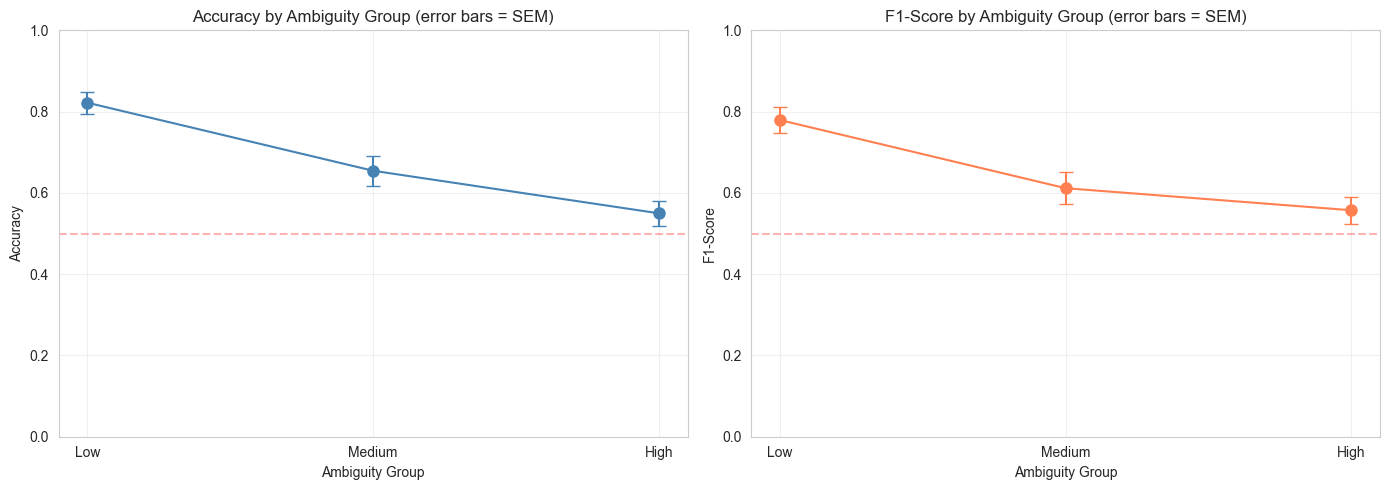

In [28]:
if len(group_results) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Accuracy with SEM error bars
    ax = axes[0]
    ax.errorbar(comparison_df['Group'], comparison_df['Accuracy'], 
                yerr=comparison_df['Accuracy_SEM'], fmt='o-', capsize=5, color='steelblue', markersize=8)
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy by Ambiguity Group (error bars = SEM)')
    ax.set_ylim([0, 1])
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    ax.grid(alpha=0.3)
    
    # F1-Score with SEM error bars
    ax = axes[1]
    ax.errorbar(comparison_df['Group'], comparison_df['F1-Score'], 
                yerr=comparison_df['F1_SEM'], fmt='o-', capsize=5, color='coral', markersize=8)
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('F1-Score')
    ax.set_title('F1-Score by Ambiguity Group (error bars = SEM)')
    ax.set_ylim([0, 1])
    ax.axhline(0.5, color='red', linestyle='--', alpha=0.3)
    ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Visualize Performance Metrics


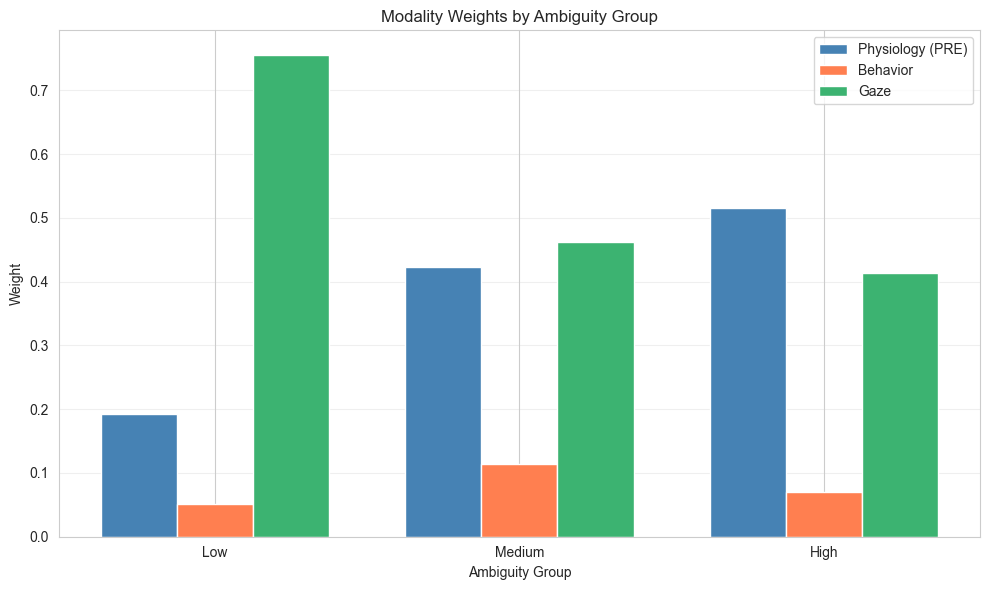

In [29]:
if len(group_results) > 0:
    # Modality weights by group
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(comparison_df))
    width = 0.25
    
    ax.bar(x - width, comparison_df['Physiology_Weight'], width, 
           label='Physiology (PRE)', color='steelblue')
    ax.bar(x, comparison_df['Behavior_Weight'], width, 
           label='Behavior', color='coral')
    ax.bar(x + width, comparison_df['Gaze_Weight'], width, 
           label='Gaze', color='mediumseagreen')
    
    ax.set_xlabel('Ambiguity Group')
    ax.set_ylabel('Weight')
    ax.set_title('Modality Weights by Ambiguity Group')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Group'])
    ax.legend()
    ax.grid(alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()

## 8. Subject-Level Accuracy Distributions

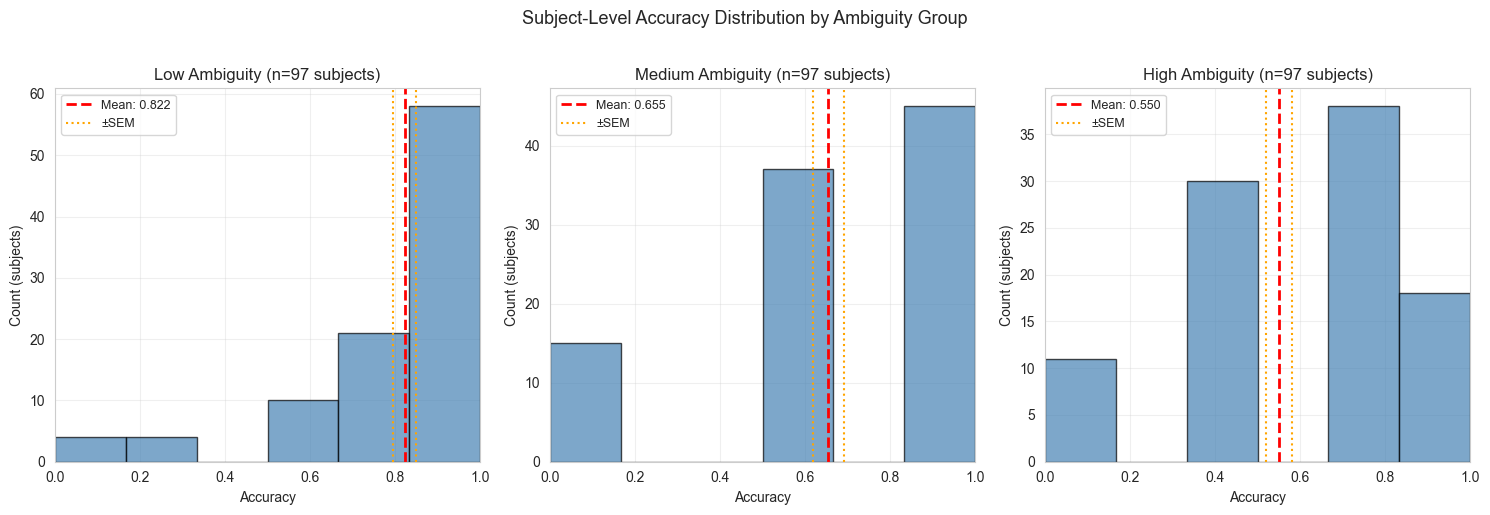

In [30]:
# Plot subject-level accuracy distributions for each ambiguity group
if len(group_results) > 0:
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for idx, (group, results) in enumerate(group_results.items()):
        ax = axes[idx]
        subject_accs = results['accuracy_per_subject']
        
        # Histogram
        ax.hist(subject_accs, bins=6, color='steelblue', alpha=0.7, edgecolor='black')
        ax.axvline(results['accuracy_mean'], color='red', linestyle='--', linewidth=2,
                   label=f"Mean: {results['accuracy_mean']:.3f}")
        ax.axvline(results['accuracy_mean'] - results['accuracy_sem'], color='orange',
                   linestyle=':', linewidth=1.5, label=f"±SEM")
        ax.axvline(results['accuracy_mean'] + results['accuracy_sem'], color='orange',
                   linestyle=':', linewidth=1.5)
        
        ax.set_xlabel('Accuracy')
        ax.set_ylabel('Count (subjects)')
        ax.set_title(f'{group} Ambiguity (n={results["n_subjects"]} subjects)')
        ax.set_xlim([0, 1])
        ax.legend(fontsize=9)
        ax.grid(alpha=0.3)
    
    plt.suptitle('Subject-Level Accuracy Distribution by Ambiguity Group', fontsize=13, y=1.02)
    plt.tight_layout()
    plt.show()

## Save Results to CSV

Exporting all results for later analysis without re-running.

In [31]:
import os
os.makedirs('../../data/results/fusion_model_results_PRE', exist_ok=True)

# Save comparison results across groups
if 'comparison_df' in locals() and comparison_df is not None:
    output_file = '../../data/results/fusion_model_results_PRE/ambiguity_group_late_fusion_balanced_PRE_comparison.csv'
    comparison_df.to_csv(output_file, index=False)
    print(f"✓ Saved comparison results to: {output_file}")
    print(f"  Contains {len(comparison_df)} groups")

# Save detailed group results
if 'group_results' in locals() and group_results:
    for group_name, results in group_results.items():
        # Save modality weights
        weights_df = pd.DataFrame({
            'Modality': results.get('modality_names', ['Physiology', 'Behavior', 'Gaze']),
            'Weight': results.get('weights', [0, 0, 0])
        })
        weights_file = '../../data/results/fusion_model_results_PRE/ambiguity_group_late_fusion_balanced_PRE_{group_name}_weights.csv'
        weights_df.to_csv(weights_file, index=False)

        # Save subject-level accuracies if available
        if 'accuracy_per_subject' in results:
            subject_df = pd.DataFrame({
                'accuracy': results['accuracy_per_subject'],
                'f1_score': results.get('f1_per_subject', [])
            })
            subject_file = '../../data/results/fusion_model_results_PRE/ambiguity_group_late_fusion_balanced_PRE_{group_name}_subject_accuracies.csv'
            subject_df.to_csv(subject_file, index=False)

    print(f"✓ Saved detailed results for {len(group_results)} groups")

print(f"\nAll results saved to: ../../data/results/fusion_model_results_PRE/")


✓ Saved comparison results to: ../../data/results/fusion_model_results_PRE/ambiguity_group_late_fusion_balanced_PRE_comparison.csv
  Contains 3 groups
✓ Saved detailed results for 3 groups

All results saved to: ../../data/results/fusion_model_results_PRE/
